# **Clone The Repository**

In [1]:
! git clone https://github.com/i1idan/solar-panel-detection-segmentation.git

Cloning into 'solar-panel-detection-segmentation'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 8 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), 1.94 KiB | 995.00 KiB/s, done.


# **Downlaod Datasets**

1.   **Modesto**
2.   **Oxnard**


In [2]:
%cd /content/solar-panel-detection-segmentation

! wget -O  metadata.zip https://figshare.com/ndownloader/articles/3385780/versions/2
! wget -O  Modesto.zip https://figshare.com/ndownloader/articles/3385789/versions/1
! wget -O  Oxnard.zip https://figshare.com/ndownloader/articles/3385807/versions/1

! mkdir data/metadata
! mkdir data/Modesto
! mkdir data/Oxnard

! unzip -q metadata.zip -d data/metadata/
! unzip -q  Modesto.zip -d data/Modesto/
! unzip -q  Oxnard.zip -d data/Oxnard/

/content/solar-panel-detection-segmentation
--2023-05-21 17:21:39--  https://figshare.com/ndownloader/articles/3385780/versions/2
Resolving figshare.com (figshare.com)... 34.255.223.158, 54.171.10.88, 2a05:d018:1f4:d000:e684:cb58:eb7d:944b, ...
Connecting to figshare.com (figshare.com)|34.255.223.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94000841 (90M) [application/zip]
Saving to: ‘metadata.zip’

metadata.zip        100%[===================>]  89.65M  22.4MB/s    in 4.0s    

2023-05-21 17:21:44 (22.4 MB/s) - ‘metadata.zip’ saved [94000841/94000841]

--2023-05-21 17:21:44--  https://figshare.com/ndownloader/articles/3385789/versions/1
Resolving figshare.com (figshare.com)... 34.255.223.158, 54.171.10.88, 2a05:d018:1f4:d000:e684:cb58:eb7d:944b, ...
Connecting to figshare.com (figshare.com)|34.255.223.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1500243762 (1.4G) [application/zip]
Saving to: ‘Modesto.zip’

Modesto.zip  

# **Install Requirements**

In [ ]:
! pip install rasterio

# **Create Solar Panles Masks Pipeline :**






In [4]:
import pandas as pd
import numpy as np
from matplotlib.path import Path as PolygonPath
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm

from typing import List, Tuple

IMAGE_SIZES = {
    'Modesto': (5000, 5000),
    'Oxnard': (4000, 6000),
}


class MaskMaker:
    """This class looks for all files defined in the metadata, and
    produces masks for all of the .tif files saved there.
    These files will be saved in <org_folder>_mask/<org_filename>.npy

    Attributes:
        data_folder: pathlib.Path
            Path of the data folder, which should be set up as described in `data/README.md`
    """

    def __init__(self, data_folder: Path = Path('data')) -> None:
        self.data_folder = data_folder

    def _read_data(self) -> Tuple[defaultdict, dict]:
        metadata_folder = self.data_folder / 'metadata'

        polygon_pixels = self._csv_to_dict_polygon_pixels(
            pd.read_csv(metadata_folder / 'polygonVertices_PixelCoordinates.csv').iloc[14803:17181]
        )
        # TODO: potentially filter on jaccard index
        polygon_images = self._csv_to_dict_image_names(
            pd.read_csv(metadata_folder / 'polygonDataExceptVertices.csv',
                        usecols=['polygon_id', 'city', 'image_name', 'jaccard_index']
                        ).iloc[14803:17181]
        )
        return polygon_images, polygon_pixels

    def process(self) -> None:

        polygon_images, polygon_pixels = self._read_data()

        for city, files in polygon_images.items():
            print(f'Processing {city}')
            # first, we make sure the mask file exists; if not,
            # we make it
            masked_city = self.data_folder / f"{city}_masks"
            x_size, y_size = IMAGE_SIZES[city]
            if not masked_city.exists(): masked_city.mkdir()

            for image, polygons in tqdm(files.items()):
                mask = np.zeros((x_size, y_size))
                for polygon in polygons:
                    mask += self.make_mask(polygon_pixels[polygon], (x_size, y_size))

                np.save(masked_city / f"{image}.npy", mask)

    @staticmethod
    def _csv_to_dict_polygon_pixels(polygon_pixels: pd.DataFrame) -> dict:
        output_dict = {}

        for idx, row in polygon_pixels.iterrows():
            vertices = []
            for i in range(1, int(row.number_vertices) + 1):
                vertices.append((row[f"lat{i}"], row[f"lon{i}"]))
            output_dict[int(row.polygon_id)] = vertices
        return output_dict

    @staticmethod
    def _csv_to_dict_image_names(polygon_images: pd.DataFrame) -> defaultdict:
        output_dict: defaultdict = defaultdict(lambda: defaultdict(list))

        for idx, row in polygon_images.iterrows():
                output_dict[row.city][row.image_name].append(int(row.polygon_id))
        return output_dict

    @staticmethod
    def make_mask(coords: List, imsizes: Tuple[int, int]) -> np.array:
        """scipy-create-2d-polygon-mask
        """
        poly_path = PolygonPath(coords)

        x_size, y_size = imsizes
        x, y = np.mgrid[:x_size, :y_size]
        coors = np.hstack((x.reshape(-1, 1), y.reshape(-1, 1)))
        mask = poly_path.contains_points(coors)

        return mask.reshape(x_size, y_size).astype(float)


# **Preprocessing**

In [5]:
import numpy as np
from numpy.random import randint
import pandas as pd
from collections import defaultdict
from pathlib import Path
import rasterio
from tqdm import tqdm

from typing import Tuple



class ImageSplitter:
    """Solar panels cover a relatively small landmass compared to
    the total image sizes, so to make sure there are contiguous solar
    panels in all segments, we will center each image on the solar panel.
    For every image, we will also randomly sample (at a buffer away from the
    solar panels) a number of images which don't contain any solar panels
    to pretrain the network

    Attributes:
        data_folder: pathlib.Path
            Path of the data folder, which should be set up as described in data/README.md
    """

    def __init__(self, data_folder: Path = Path('data')) -> None:
        self.data_folder = data_folder

        # setup; make the necessary folders
        self.processed_folder = data_folder / 'processed'
        if not self.processed_folder.exists(): self.processed_folder.mkdir()

        self.solar_panels = self._setup_folder('solar')
        self.empty = self._setup_folder('empty')

    def _setup_folder(self, folder_name: str) -> Path:

        full_folder_path = self.processed_folder / folder_name
        if not full_folder_path.exists(): full_folder_path.mkdir()

        for subfolder in ['org', 'mask']:
            subfolder_name = full_folder_path / subfolder
            if not subfolder_name.exists(): subfolder_name.mkdir()

        return full_folder_path

    def read_centroids(self) -> defaultdict:

        metadata = pd.read_csv(self.data_folder / 'metadata/polygonDataExceptVertices.csv',
                               usecols=['city', 'image_name', 'centroid_latitude_pixels',
                                        'centroid_longitude_pixels']).iloc[14803:17181]
        org_len = len(metadata)
        metadata = metadata.dropna()
        print(f'Dropped {org_len - len(metadata)} rows due to NaN values')

        # for each image, we want to know where the solar panel centroids are
        output_dict: defaultdict = defaultdict(lambda: defaultdict(set))

        for idx, row in metadata.iterrows():
            output_dict[row.city][row.image_name].add((
                row.centroid_latitude_pixels, row.centroid_longitude_pixels
            ))
        return output_dict

    @staticmethod
    def adjust_coords(coords: Tuple[float, float], image_radius: int,
                      org_imsize: Tuple[int, int]) -> Tuple[float, float]:
        x_imsize, y_imsize = org_imsize
        x, y = coords
        # we make sure that the centroid isn't at the edge of the image
        if x < image_radius: x = image_radius
        elif x > (x_imsize - image_radius): x = x_imsize - image_radius

        if y < image_radius: y = image_radius
        elif y > (y_imsize - image_radius): y = y_imsize - image_radius
        return x, y

    @staticmethod
    def size_okay(image: np.array, imsize: int) -> bool:
        if image.shape == (3, imsize, imsize):
            return True
        return False

    def process(self, imsize: int=224, empty_ratio: int=2) -> None:
        """Creates the solar and empty images, and their corresponding masks

        Parameters
        ----------
        imsize: int, default: 224
            The size of the images to be generated
        empty_ratio: int, default: 2
            The ratio of images without solar panels to images with solar panels.
            Because images without solar panels are randomly sampled with limited
            patience, having this number slightly > 1 yields a roughly 1:1 ratio.

        Images and masks are saved in {solar, empty}/{org_mask}, with their original
        city in their filename (i.e. {city}_{idx}.npy) where idx is incremented with every
        image-mask combination saved to ensure uniqueness
        """

        image_radius = imsize // 2
        centroids_dict = self.read_centroids()

        im_idx = 0
        for city, images in centroids_dict.items():
            print(f"Processing {city}")
            for image_name, centroids in tqdm(images.items()):

                org_file = rasterio.open(self.data_folder / f"{city}/{image_name}.tif").read()

                org_x_imsize, org_y_imsize = IMAGE_SIZES[city]
                if org_file.shape != (3, org_x_imsize, org_y_imsize):
                    print(f'{city}/{image_name}.tif is malformed with shape {org_file.shape}. '
                          f'Skipping!')
                    continue
                mask_file = np.load(self.data_folder / f"{city}_masks/{image_name}.npy")

                # first, lets collect the positive examples
                for centroid in centroids:
                    x, y = self.adjust_coords(centroid, image_radius, (org_x_imsize, org_y_imsize))
                    max_width, max_height = int(x + image_radius), int(y + image_radius)
                    min_width, min_height = max_width - imsize, max_height - imsize

                    clipped_orgfile = org_file[:, min_width: max_width, min_height: max_height]
                    mask = mask_file[min_width: max_width, min_height: max_height]

                    if self.size_okay(clipped_orgfile, imsize):
                        np.save(self.solar_panels / f"org/{city}_{im_idx}.npy", clipped_orgfile)
                        np.save(self.solar_panels / f"mask/{city}_{im_idx}.npy", mask)

                        im_idx += 1

                # next, the negative examples. We randomly search for negative examples
                # until we have a) found the number we want, or b) hit positive examples
                # too often (and maxed out our patience), in which case we give up
                # this is a crude way of doing it, and could probably be improved
                patience, max_patience = 0, 10
                num_empty, max_num_empty = 0, len(centroids) * empty_ratio
                while (patience < max_patience) and (num_empty < max_num_empty):
                    rand_x = randint(0, org_x_imsize - imsize)
                    rand_y = randint(0, org_y_imsize - imsize)
                    rand_x_max, rand_y_max = rand_x + imsize, rand_y + imsize
                    # this makes sure no solar panel is present
                    mask_candidate = mask_file[rand_x: rand_x_max, rand_y: rand_y_max]

                    if mask_candidate.sum() == 0:
                        clipped_orgfile = org_file[:, rand_x: rand_x_max, rand_y: rand_y_max]
                        if self.size_okay(clipped_orgfile, imsize):
                            np.save(self.empty / f"org/{city}_{im_idx}.npy",
                                    org_file[:, rand_x: rand_x_max, rand_y: rand_y_max])
                            np.save(self.empty / f"mask/{city}_{im_idx}.npy",
                                    mask_candidate)
                            im_idx += 1
                            num_empty += 1
                    else:
                        patience += 1
        print(f"Generated {im_idx} samples")


# **Utilities and Augmentations Functions**

In [6]:
import numpy as np

from typing import List, Tuple

MEAN, STD = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]


def normalize(image: np.ndarray) -> np.ndarray:
    """Normalized an image (or a set of images), as per

    Specifically, images are normalized to range [0, 1], and
    then normalized according to ImageNet stats.
    """
    image = image / 255

    # determine if we are dealing with a single image, or a
    # stack of images. If a stack, expected in (batch, channels, height, width)
    source, dest = 0 if len(image.shape) == 3 else 1, -1

    # moveaxis for array broadcasting, and then back so its how pytorch expects it
    return np.moveaxis((np.moveaxis(image, source, dest) - MEAN) / STD, dest, source)


def denormalize(image: np.ndarray) -> np.ndarray:
    """Reverses what normalize does
    """
    # determine if we are dealing with a single image, or a
    # stack of images. If a stack, expected in (batch, channels, height, width)
    source, dest = 0 if len(image.shape) == 3 else 1, -1

    image = np.moveaxis((np.moveaxis(image, source, dest) * STD) + MEAN, dest, source)
    return (image * 255).astype(int)


def make_masks(
    dataset_length: int,
    val_size: float = 0.1,
    test_size: float = 0.1
    ) -> Tuple[List[bool], List[bool], List[bool]]:
    """Returns three boolean arrays of length `dataset_length`,
    representing the train set, validation set and test set. These
    arrays can be passed to `Dataset.add_mask` to yield the appropriate
    datasets.
    """
    mask = np.random.rand(dataset_length)
    train_mask = mask < (1 - (val_size + test_size))
    val_mask = (mask >= (1 - (val_size + test_size))) & (mask < 1 - test_size)
    test_mask = mask >= (1 - test_size)

    return train_mask, val_mask, test_mask


In [7]:
"""
Image transformations, along with their corresponding
mask transformations (if applicable)
"""

import numpy as np
from typing import Tuple, Optional


def no_change(image: np.ndarray,
              mask: Optional[np.ndarray] = None) -> Tuple[np.ndarray,
                                                          Optional[np.ndarray]]:
    if mask is None: return image
    return image, mask


def horizontal_flip(image: np.ndarray,
                    mask: Optional[np.ndarray] = None) -> Tuple[np.ndarray,
                                                                Optional[np.ndarray]]:
    # input: image[channels, height, width]
    image = image[:, :, ::-1]
    if mask is None: return image

    mask = mask[:, ::-1]
    return image, mask


def vertical_flip(image: np.ndarray,
                  mask: Optional[np.ndarray] = None) -> Tuple[np.ndarray,
                                                              Optional[np.ndarray]]:
    # input: image[channels, height, width]
    image = image[:, ::-1, :]
    if mask is None: return image

    mask = mask[::-1, :]
    return image, mask


def colour_jitter(image: np.ndarray,
                  mask: Optional[np.ndarray] = None) -> Tuple[np.ndarray,
                                                              Optional[np.ndarray]]:
    _, height, width = image.shape
    zitter = np.zeros_like(image)

    for channel in range(zitter.shape[0]):
        noise = np.random.randint(0, 30, (height, width))
        zitter[channel, :, :] = noise

    image = image + zitter
    if mask is None: return image
    return image, mask


# **Detection Dataloader**

In [8]:
import numpy as np
import torch
from pathlib import Path
import random

from typing import Optional, List, Tuple



class ClassifierDataset:

    def __init__(self,
                 processed_folder: Path=Path('data/processed'),
                 normalize: bool = True, transform_images: bool = False,
                 device: torch.device = torch.device('cuda:0' if
                                                     torch.cuda.is_available() else 'cpu'),
                 mask: Optional[List[bool]] = None) -> None:

        self.device = device
        self.normalize = normalize
        self.transform_images = transform_images

        solar_files = list((processed_folder / 'solar/org').glob("*.npy"))
        empty_files = list((processed_folder / 'empty/org').glob("*.npy"))

        self.y = torch.as_tensor([1 for _ in solar_files] + [0 for _ in empty_files],
                                 device=self.device).float()
        self.x_files = solar_files + empty_files

        if mask is not None:
            self.add_mask(mask)

    def add_mask(self, mask: List[bool]) -> None:
        """Add a mask to the data
        """
        assert len(mask) == len(self.x_files), \
            f"Mask is the wrong size! Expected {len(self.x_files)}, got {len(mask)}"
        self.y = torch.as_tensor(self.y.cpu().numpy()[mask], device=self.device)
        self.x_files = [x for include, x in zip(mask, self.x_files) if include]

    def __len__(self) -> int:
        return self.y.shape[0]

    def _transform_images(self, image: np.ndarray) -> np.ndarray:
        transforms = [
            no_change,
            horizontal_flip,
            vertical_flip,
            colour_jitter,
        ]
        chosen_function = random.choice(transforms)
        return chosen_function(image)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        y = self.y[index]
        x = np.load(self.x_files[index])
        if self.transform_images: x = self._transform_images(x)
        if self.normalize: x = normalize(x)
        return torch.as_tensor(x.copy(), device=self.device).float(), y


# **Segmentation Dataloader**

In [9]:
import numpy as np
import torch
from pathlib import Path
import random

from typing import Optional, List, Tuple



class SegmenterDataset:
    def __init__(self,
                 processed_folder: Path = Path('data/processed'),
                 normalize: bool = True, transform_images: bool = True,
                 device: torch.device = torch.device('cuda:0' if
                                                     torch.cuda.is_available() else 'cpu'),
                 mask: Optional[List[bool]] = None) -> None:

        self.device = device
        self.normalize = normalize
        self.transform_images = transform_images

        # We will only segment the images which we know have solar panels in them; the
        # other images should be filtered out by the classifier
        solar_folder = processed_folder / 'solar'

        self.org_solar_files = list((solar_folder / 'org').glob("*.npy"))
        self.mask_solar_files = [solar_folder / 'mask' / f.name for f in self.org_solar_files]

        if mask is not None:
            self.add_mask(mask)

    def add_mask(self, mask: List[bool]) -> None:
        """Add a mask to the data
        """
        assert len(mask) == len(self.org_solar_files), \
            f"Mask is the wrong size! Expected {len(self.org_solar_files)}, got {len(mask)}"
        self.org_solar_files = [x for include, x in zip(mask, self.org_solar_files) if include]
        self.mask_solar_files = [x for include, x in zip(mask, self.mask_solar_files) if include]

    def __len__(self) -> int:
        return len(self.org_solar_files)

    def _transform_images(self, image: np.ndarray,
                          mask: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        transforms = [
            no_change,
            horizontal_flip,
            vertical_flip,
            colour_jitter,
        ]
        chosen_function = random.choice(transforms)
        return chosen_function(image, mask)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:

        x = np.load(self.org_solar_files[index])
        y = np.load(self.mask_solar_files[index])
        if self.transform_images: x, y = self._transform_images(x, y)
        if self.normalize: x = normalize(x)
        return torch.as_tensor(x.copy(), device=self.device).float(), \
            torch.as_tensor(y.copy(), device=self.device).float()


# **PreTrain Model Architecture**

In [10]:
import torch
from torch import nn
from torchvision.models import resnet34


class ResnetBase(nn.Module):
    """ResNet pretrained on Imagenet. This serves as the
    base for the classifier, and subsequently the segmentation model

    Attributes:
        imagenet_base: boolean, default: True
            Whether or not to load weights pretrained on imagenet
    """
    def __init__(self, imagenet_base: bool = True) -> None:
        super().__init__()

        resnet = resnet34(pretrained=imagenet_base).float()
        self.pretrained = nn.Sequential(*list(resnet.children())[:-2])

    def forward(self, x):
        # Since this is just a base, forward() shouldn't directly
        # be called on it.
        raise NotImplementedError


# **Detector Architecture**

In [11]:
import torch
from torch import nn

# from .base import ResnetBase


class Classifier(ResnetBase):
    """A ResNet34 Model

    Attributes:
        imagenet_base: boolean, default: True
            Whether or not to load weights pretrained on imagenet
    """

    def __init__(self, imagenet_base: bool = True) -> None:
        super().__init__(imagenet_base=imagenet_base)

        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.classifier = nn.Sequential(
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.pretrained(x)
        x = self.avgpool(x)
        return self.classifier(x.view(x.size(0), -1))


# **Define Unet / Segmenter Architecture**

In [12]:
import torch
from torch import nn

from typing import List


class Segmenter(ResnetBase):
    """A ResNet34 U-Net model

    Attributes:
        imagenet_base: boolean, default: False
            Whether or not to load weights pretrained on imagenet
    """

    def __init__(self, imagenet_base: bool = False) -> None:
        super().__init__(imagenet_base=imagenet_base)

        self.target_modules = [str(x) for x in [2, 4, 5, 6]]
        self.hooks = self.add_hooks()

        self.relu = nn.ReLU()
        self.upsamples = nn.ModuleList([
            UpBlock(512, 256, 256),
            UpBlock(256, 128, 256),
            UpBlock(256, 64, 256),
            UpBlock(256, 64, 256),
            UpBlock(256, 3, 16),
        ])
        self.conv_transpose = nn.ConvTranspose2d(16, 1, 1)
        self.sigmoid = nn.Sigmoid()

    def add_hooks(self) -> List[torch.utils.hooks.RemovableHandle]:
        hooks = []
        for name, child in self.pretrained.named_children():
            if name in self.target_modules:
                hooks.append(child.register_forward_hook(self.save_output))
        return hooks

    def retrieve_hooked_outputs(self) -> List[torch.Tensor]:
        # to be called in the forward pass, this method returns the tensors
        # which were saved by the forward hooks
        outputs = []
        for name, child in self.pretrained.named_children():
            if name in self.target_modules:
                outputs.append(child.output)
        return outputs

    def cleanup(self) -> None:
        # removes the hooks, and the tensors which were added
        for name, child in self.pretrained.named_children():
            if name in self.target_modules:
                # allows the method to be safely called even if
                # the hooks aren't there
                try: del child.output
                except AttributeError: continue
        for hook in self.hooks: hook.remove()

    @staticmethod
    def save_output(module, input, output):
        # the hook to add to the target modules
        module.output = output

    def load_base(self, state_dict: dict) -> None:
        # This allows a model trained on the classifier to be loaded
        # into the model used for segmentation, even though their state_dicts
        # differ
        self.load_state_dict(state_dict, strict=False)

    def forward(self, x):
        org_input = x
        x = self.relu(self.pretrained(x))
        # we reverse the outputs so that the smallest output
        # is the first one we get, and the largest the last
        interim = self.retrieve_hooked_outputs()[::-1]

        for upsampler, interim_output in zip(self.upsamples[:-1], interim):
            x = upsampler(x, interim_output)
        x = self.upsamples[-1](x, org_input)
        return self.sigmoid(self.conv_transpose(x))


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, across_channels: int,
                 out_channels: int) -> None:
        super().__init__()
        up_out = across_out = out_channels // 2
        self.conv_across = nn.Conv2d(across_channels, across_out, 1)
        self.conv_transpose = nn.ConvTranspose2d(in_channels, up_out, 2, stride=2)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x_up, x_across):
        joint = torch.cat((self.conv_transpose(x_up), self.conv_across(x_across)), dim=1)
        return self.batchnorm(self.relu(joint))


# **Training Loop**

In [13]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.optimizer import Optimizer
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, jaccard_score

from typing import Any, List, Tuple


def train_classifier(model: torch.nn.Module,
                     train_dataloader: DataLoader,
                     val_dataloader: DataLoader,
                     warmup: int = 2,
                     patience: int = 5,
                     max_epochs: int = 100) -> None:
    """Train the classifier

    Parameters
    ----------
    model
        The classifier to be trained
    train_dataloader:
        An iterator which returns batches of training images and labels from the
        training dataset
    val_dataloader:
        An iterator which returns batches of training images and labels from the
        validation dataset
    warmup: int, default: 2
        The number of epochs for which only the final layers (not from the ResNet base)
        should be trained
    patience: int, default: 5
        The number of epochs to keep training without an improvement in performance on the
        validation set before early stopping
    max_epochs: int, default: 100
        The maximum number of epochs to train for
    """

    best_state_dict = model.state_dict()
    best_val_auc_roc = 0.5
    patience_counter = 0
    for i in range(max_epochs):
        print(100*"-")
        print(f'Epoch: {i}')
        if i <= warmup:
            # we start by finetuning the model
            optimizer = torch.optim.Adam([pam for name, pam in
                                          model.named_parameters() if 'classifier' in name])
        else:
            # then, we train the whole thing
            optimizer = torch.optim.Adam(model.parameters())

        train_data, val_data = _train_classifier_epoch(model, optimizer, train_dataloader,
                                                       val_dataloader)
        if val_data[1] > best_val_auc_roc:
            best_val_auc_roc = val_data[1]
            patience_counter = 0
            best_state_dict = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter == patience:
                print("Early stopping!")
                model.load_state_dict(best_state_dict)
                return None


def train_segmenter(model: torch.nn.Module,
                    train_dataloader: DataLoader,
                    val_dataloader: DataLoader,
                    warmup: int = 2,
                    patience: int = 5,
                    max_epochs: int = 100) -> None:
    """Train the segmentation model

    Parameters
    ----------
    model
        The segmentation model to be trained
    train_dataloader:
        An iterator which returns batches of training images and masks from the
        training dataset
    val_dataloader:
        An iterator which returns batches of training images and masks from the
        validation dataset
    warmup: int, default: 2
        The number of epochs for which only the upsampling layers (not trained by the classifier)
        should be trained
    patience: int, default: 5
        The number of epochs to keep training without an improvement in performance on the
        validation set before early stopping
    max_epochs: int, default: 100
        The maximum number of epochs to train for
    """
    best_state_dict = model.state_dict()
    best_loss = 1
    patience_counter = 0
    for i in range(max_epochs):

        print(100*"-")
        print(f'Epoch: {i}')

        if i <= warmup:
            # we start by 'warming up' the final layers of the model
            optimizer = torch.optim.Adam([pam for name, pam in
                                          model.named_parameters() if 'pretrained' not in name])
        else:
            optimizer = torch.optim.Adam(model.parameters())

        train_data, val_data = _train_segmenter_epoch(model, optimizer, train_dataloader,
                                                      val_dataloader)
        if np.mean(val_data) < best_loss:
            best_loss = np.mean(val_data)
            patience_counter = 0
            best_state_dict = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter == patience:
                print("Early stopping!")
                model.load_state_dict(best_state_dict)
                return None


def _train_classifier_epoch(model: torch.nn.Module,
                            optimizer: Optimizer,
                            train_dataloader: DataLoader,
                            val_dataloader: DataLoader
                            ) -> Tuple[Tuple[List[Any], float],
                                       Tuple[List[Any], float]]:

    t_losses, t_true, t_pred = [], [], []
    v_losses, v_true, v_pred = [], [], []
    model.train()
    for x, y in tqdm(train_dataloader):
        optimizer.zero_grad()
        preds = model(x)

        loss = F.binary_cross_entropy(preds.squeeze(1), y)
        loss.backward()
        optimizer.step()
        t_losses.append(loss.item())

        t_true.append(y.cpu().detach().numpy())
        t_pred.append(preds.squeeze(1).cpu().detach().numpy())

    with torch.no_grad():
        model.eval()
        for val_x, val_y in tqdm(val_dataloader):
            val_preds = model(val_x)
            val_loss = F.binary_cross_entropy(val_preds.squeeze(1), val_y)
            v_losses.append(val_loss.item())

            v_true.append(val_y.cpu().detach().numpy())
            v_pred.append(val_preds.squeeze(1).cpu().detach().numpy())

    train_auc = roc_auc_score(np.concatenate(t_true), np.concatenate(t_pred))
    val_auc = roc_auc_score(np.concatenate(v_true), np.concatenate(v_pred))


    
    train_accuracy = accuracy_score(np.concatenate(t_true), np.concatenate(t_pred).round())
    val_accuracy = accuracy_score(np.concatenate(v_true), np.concatenate(v_pred).round())

    print()
    print(f'Train loss: {np.mean(t_losses)}, Train AUC ROC: {train_auc}, Train Accuracy: {np.mean(train_accuracy)}')
    print()
    print(f'Val loss: {np.mean(v_losses)}, Val AUC ROC: {val_auc}, Val Accuracy: {val_accuracy}')
    print(100*"-")

    return (t_losses, train_auc), (v_losses, val_auc)

def dice(pred, true, k = 1):

    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

def _train_segmenter_epoch(model: torch.nn.Module,
                           optimizer: Optimizer,
                           train_dataloader: DataLoader,
                           val_dataloader: DataLoader
                           ) -> Tuple[List[Any], List[Any]]:
    t_losses, v_losses = [], []
    model.train()
    for x, y in tqdm(train_dataloader):
        optimizer.zero_grad()
        preds = model(x)

        loss = F.binary_cross_entropy(preds, y.unsqueeze(1))
        loss.backward()
        optimizer.step()

        t_losses.append(loss.item())

    with torch.no_grad():
        model.eval()
        for val_x, val_y in tqdm(val_dataloader):
            val_preds = model(val_x)
            val_loss = F.binary_cross_entropy(val_preds, val_y.unsqueeze(1))
            v_losses.append(val_loss.item())



    print()
    print(f'Train loss: {np.mean(t_losses)}, Val loss: {np.mean(v_losses)}')
    print(100*"-")

    return t_losses, v_losses


# **Task Runner**

In [275]:
import torch
from torch.utils.data import DataLoader

import numpy as np
from pathlib import Path
from tqdm import tqdm



class RunTask:

    @staticmethod
    def make_masks(data_folder='data'):
        """Saves masks for each .tif image in the raw dataset. Masks are saved
        in  <org_folder>_mask/<org_filename>.npy where <org_folder> should be the
        city name, as defined in `data/README.md`.

        Parameters
        ----------
        data_folder: pathlib.Path
            Path of the data folder, which should be set up as described in `data/README.md`
        """
        mask_maker = MaskMaker(data_folder=Path(data_folder))
        mask_maker.process()

    @staticmethod
    def split_images(data_folder='data', imsize=224, empty_ratio=2):
        """Generates images (and their corresponding masks) of height = width = imsize
        for input into the models.

        Parameters
        ----------
        data_folder: pathlib.Path
            Path of the data folder, which should be set up as described in `data/README.md`
        imsize: int, default: 224
            The size of the images to be generated
        empty_ratio: int, default: 2
            The ratio of images without solar panels to images with solar panels.
            Because images without solar panels are randomly sampled with limited
            patience, having this number slightly > 1 yields a roughly 1:1 ratio.
        """
        splitter = ImageSplitter(data_folder=Path(data_folder))
        splitter.process(imsize=imsize, empty_ratio=empty_ratio)

    @staticmethod
    def train_classifier(max_epochs=100, warmup=2, patience=5, val_size=0.1,
                         test_size=0.1, data_folder='data',
                         device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')):
        """Train the classifier

        Parameters
        ----------
        max_epochs: int, default: 100
            The maximum number of epochs to train for
        warmup: int, default: 2
            The number of epochs for which only the final layers (not from the ResNet base)
            should be trained
        patience: int, default: 5
            The number of epochs to keep training without an improvement in performance on the
            validation set before early stopping
        val_size: float < 1, default: 0.1
            The ratio of the entire dataset to use for the validation set
        test_size: float < 1, default: 0.1
            The ratio of the entire dataset to use for the test set
        data_folder: pathlib.Path
            Path of the data folder, which should be set up as described in `data/README.md`
        device: torch.device, default: cuda if available, else cpu
            The device to train the models on
        """
        data_folder = Path(data_folder)

        model = Classifier()
        if device.type != 'cpu': model = model.cuda()

        processed_folder = data_folder / 'processed'
        dataset = ClassifierDataset(processed_folder=processed_folder)

        # make a train and val set
        train_mask, val_mask, test_mask = make_masks(len(dataset), val_size, test_size)

        dataset.add_mask(train_mask)
        train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
        val_dataloader = DataLoader(ClassifierDataset(mask=val_mask,
                                                      processed_folder=processed_folder,
                                                      transform_images=False),
                                    batch_size=64, shuffle=True)
        test_dataloader = DataLoader(ClassifierDataset(mask=test_mask,
                                                       processed_folder=processed_folder,
                                                       transform_images=False),
                                     batch_size=64)

        train_classifier(model, train_dataloader, val_dataloader, max_epochs=max_epochs,
                         warmup=warmup, patience=patience)

        savedir = data_folder / 'models'
        if not savedir.exists(): savedir.mkdir()
        torch.save(model.state_dict(), savedir / 'classifier.model')

        # save predictions for analysis
        print("Generating test results")
        preds, true = [], []
        with torch.no_grad():
            for test_x, test_y in tqdm(test_dataloader):
                test_preds = model(test_x)
                preds.append(test_preds.squeeze(1).cpu().numpy())
                true.append(test_y.cpu().numpy())

        np.save(savedir / 'classifier_preds.npy', np.concatenate(preds))
        np.save(savedir / 'classifier_true.npy', np.concatenate(true))

    @staticmethod
    def train_segmenter(max_epochs=100, val_size=0.1, test_size=0.1, warmup=2,
                        patience=5, data_folder='data', use_classifier=True,
                        device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')):
        """Train the segmentation model

        Parameters
        ----------
        max_epochs: int, default: 100
            The maximum number of epochs to train for
        warmup: int, default: 2
            The number of epochs for which only the final layers (not from the ResNet base)
            should be trained
        patience: int, default: 5
            The number of epochs to keep training without an improvement in performance on the
            validation set before early stopping
        val_size: float < 1, default: 0.1
            The ratio of the entire dataset to use for the validation set
        test_size: float < 1, default: 0.1
            The ratio of the entire dataset to use for the test set
        data_folder: pathlib.Path
            Path of the data folder, which should be set up as described in `data/README.md`
        use_classifier: boolean, default: True
            Whether to use the pretrained classifier (saved in data/models/classifier.model by the
            train_classifier step) as the weights for the downsampling step of the segmentation
            model
        device: torch.device, default: cuda if available, else cpu
            The device to train the models on
        """
        data_folder = Path(data_folder)
        model = Segmenter()
        if device.type != 'cpu': model = model.cuda()

        model_dir = data_folder / 'models'
        if use_classifier:
            classifier_sd = torch.load(model_dir / 'classifier.model')
            model.load_base(classifier_sd)
        processed_folder = data_folder / 'processed'
        dataset = SegmenterDataset(processed_folder=processed_folder)
        train_mask, val_mask, test_mask = make_masks(len(dataset), val_size, test_size)

        dataset.add_mask(train_mask)
        train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
        val_dataloader = DataLoader(SegmenterDataset(mask=val_mask,
                                                     processed_folder=processed_folder,
                                                     transform_images=False),
                                    batch_size=64, shuffle=True)
        test_dataloader = DataLoader(SegmenterDataset(mask=test_mask,
                                                      processed_folder=processed_folder,
                                                      transform_images=False),
                                     batch_size=64)

        train_segmenter(model, train_dataloader, val_dataloader, max_epochs=max_epochs,
                        warmup=warmup, patience=patience)

        if not model_dir.exists(): model_dir.mkdir()
        torch.save(model.state_dict(), model_dir / 'segmenter.model')

        print("Generating test results")
        images, preds, true = [], [], []
        with torch.no_grad():
            for test_x, test_y in tqdm(test_dataloader):
                test_preds = model(test_x)
                images.append(test_x.cpu().numpy())
                preds.append(test_preds.squeeze(1).cpu().numpy())
                true.append(test_y.cpu().numpy())

        
        print()
        dice_coefficient_value = dice(np.concatenate(preds), np.concatenate(true))
        print(f"test dice coefficient: {dice_coefficient_value}")

        np.save(model_dir / 'segmenter_images.npy', np.concatenate(images))
        np.save(model_dir / 'segmenter_preds.npy', np.concatenate(preds))
        np.save(model_dir / 'segmenter_true.npy', np.concatenate(true))

    def train_both(self, c_max_epochs=100, c_warmup=2, c_patience=5, c_val_size=0.1,
                   c_test_size=0.1, s_max_epochs=100, s_warmup=2, s_patience=5,
                   s_val_size=0.1, s_test_size=0.1, data_folder='data',
                   device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')):
        """Train the classifier, and use it to train the segmentation model.
        """
        data_folder = Path(data_folder)
        self.train_classifier(max_epochs=c_max_epochs, val_size=c_val_size, test_size=c_test_size,
                              warmup=c_warmup, patience=c_patience, data_folder=data_folder,
                              device=device)
        self.train_segmenter(max_epochs=s_max_epochs, val_size=s_val_size, test_size=s_test_size,
                             warmup=s_warmup, patience=s_patience, use_classifier=True,
                             data_folder=data_folder, device=device)
    def visualize_results(self,  data_folder='data'):
        """visualize segmentation results for the test images
        """
        model_dir = data_folder + '/models'
                
        images = np.load(model_dir + "/segmenter_images.npy")
        true = np.load(model_dir +  "/segmenter_true.npy")
        preds = np.load(model_dir + "/segmenter_preds.npy")

        show_num = 10
        fig, ax = plt.subplots(show_num, 3, figsize=(13, 50))

        for i, pred in enumerate(preds[:show_num]):
            ax[i, 0].imshow(np.clip(images[i], 0, 1).T, cmap='gray')
            ax[i, 0].set_title('Original Image')
            ax[i, 1].imshow(true[i].T, cmap='gray')
            ax[i, 1].set_title('Ground Truth')
            ax[i, 2].imshow(preds[i].T, cmap='gray')
            ax[i, 2].set_title('Predicted Mask')

    def predict(self,  array_path="/sample_data/Oxnard_1692.npy" , data_folder='data'):
        """visualize segmentation results for the test images
        """
        model_dir = data_folder + '/models'
        model = Classifier()
        model.load_state_dict(torch.load(model_dir + "/classifier.model"))
        model.eval()
        seg = Segmenter()
        seg.load_state_dict(torch.load(model_dir + "/segmenter.model"))
        seg.eval()
        image = np.load(data_folder + array_path)
        array = normalize(image)
        array = torch.from_numpy(array)

        input = torch.tensor(array)
        input = torch.tensor(input.view(1, 3, 224,224), dtype=torch.float32)

        output = seg(input)
        prob = model(input)

        print(f"solar panel existence probablity:{prob.item()}")
        print()
        print("solar panel area:")
        mask = output.detach().numpy()
        # fig, ax = plt.subplots(1, 2)
        # ax[0, 0].imshow(, cmap='gray')
        # ax[0, 0].set_title('Original Image')
        # ax[0, 1].imshow((mask.squeeze().T).astype("uint8"), cmap='gray')
        # ax[0, 1].set_title('Predicted Mask')

        f = plt.figure()
        f.add_subplot(1, 2, 1)
        plt.imshow(image.T)
        plt.title('Original Image')
        f.add_subplot(1,2, 2)
        plt.imshow((mask.squeeze().T).astype("uint8"), cmap='gray')
        plt.title('Predicted Mask')
        plt.show(block=True)




In [276]:
runner = RunTask()

In [17]:
runner.make_masks()

Processing Modesto


100%|██████████| 19/19 [17:00<00:00, 53.70s/it]


Processing Oxnard


100%|██████████| 52/52 [45:04<00:00, 52.02s/it]


In [ ]:
runner.split_images()

In [19]:
runner.train_classifier()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 84.3MB/s]


----------------------------------------------------------------------------------------------------
Epoch: 0


100%|██████████| 10/10 [00:03<00:00,  3.09it/s]



Train loss: 0.5448196926399281, Train AUC ROC: 0.783912962512609, Train Accuracy: 0.7111065320420359

Val loss: 0.4591336339712143, Val AUC ROC: 0.8671070309001343, Val Accuracy: 0.7844408427876823
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 1


100%|██████████| 10/10 [00:01<00:00,  5.93it/s]



Train loss: 0.4340182182035948, Train AUC ROC: 0.8749509968164397, Train Accuracy: 0.7885843807953843

Val loss: 0.43790083527565005, Val AUC ROC: 0.8823331840573221, Val Accuracy: 0.7828200972447326
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 2


100%|██████████| 10/10 [00:01<00:00,  5.49it/s]



Train loss: 0.40861348396069125, Train AUC ROC: 0.8881253313612185, Train Accuracy: 0.7999175767566453

Val loss: 0.3975621432065964, Val AUC ROC: 0.8881773399014777, Val Accuracy: 0.8087520259319287
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 3


100%|██████████| 10/10 [00:01<00:00,  5.77it/s]



Train loss: 0.3808842407245385, Train AUC ROC: 0.916095600804845, Train Accuracy: 0.8427776633010509

Val loss: 0.2267288863658905, Val AUC ROC: 0.9601768920734438, Val Accuracy: 0.9238249594813615
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 4


100%|██████████| 10/10 [00:01<00:00,  5.57it/s]



Train loss: 0.22253702982868018, Train AUC ROC: 0.967023038350488, Train Accuracy: 0.9155161755615083

Val loss: 0.1595150575041771, Val AUC ROC: 0.9819077474249888, Val Accuracy: 0.9367909238249594
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 5


100%|██████████| 10/10 [00:01<00:00,  5.81it/s]



Train loss: 0.1502762137863197, Train AUC ROC: 0.9832360153548649, Train Accuracy: 0.950752112095611

Val loss: 0.16823126524686813, Val AUC ROC: 0.9784258844603672, Val Accuracy: 0.946515397082658
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 6


100%|██████████| 10/10 [00:01<00:00,  5.64it/s]



Train loss: 0.10525037490419652, Train AUC ROC: 0.9922385366376464, Train Accuracy: 0.9575520296723676

Val loss: 0.24941426515579224, Val AUC ROC: 0.9778101209135691, Val Accuracy: 0.9367909238249594
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 7


100%|██████████| 10/10 [00:01<00:00,  5.72it/s]



Train loss: 0.09252976053271834, Train AUC ROC: 0.9933838135853026, Train Accuracy: 0.9680609932000824

Val loss: 0.13838367350399494, Val AUC ROC: 0.9855239587998208, Val Accuracy: 0.9562398703403565
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 8


100%|██████████| 10/10 [00:01<00:00,  5.61it/s]



Train loss: 0.06831447788710265, Train AUC ROC: 0.9956690265341781, Train Accuracy: 0.979188131052957

Val loss: 0.1972563773393631, Val AUC ROC: 0.982769816390506, Val Accuracy: 0.9481361426256077
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 9


100%|██████████| 10/10 [00:01<00:00,  5.31it/s]



Train loss: 0.05694833524696725, Train AUC ROC: 0.9976306671447407, Train Accuracy: 0.9793941891613435

Val loss: 0.1268592868000269, Val AUC ROC: 0.9866323331840572, Val Accuracy: 0.9578606158833063
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 10


100%|██████████| 10/10 [00:01<00:00,  5.81it/s]



Train loss: 0.03987898064722111, Train AUC ROC: 0.9985923045507354, Train Accuracy: 0.9870183391716464

Val loss: 0.28258097395300863, Val AUC ROC: 0.9737908643081057, Val Accuracy: 0.9513776337115073
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 11


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]



Train loss: 0.04128737909272068, Train AUC ROC: 0.9983788447248005, Train Accuracy: 0.9845456418710076

Val loss: 0.3027006149291992, Val AUC ROC: 0.972704881325571, Val Accuracy: 0.9416531604538088
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 12


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]



Train loss: 0.03198964740027135, Train AUC ROC: 0.9991755359016639, Train Accuracy: 0.989078920255512

Val loss: 0.1617702804505825, Val AUC ROC: 0.9847962382445141, Val Accuracy: 0.9481361426256077
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 13


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]



Train loss: 0.03434794854164418, Train AUC ROC: 0.9989648355647214, Train Accuracy: 0.9896970945806718

Val loss: 0.24907355655450375, Val AUC ROC: 0.9809001343484102, Val Accuracy: 0.9578606158833063
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 14


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]



Train loss: 0.025982853078810302, Train AUC ROC: 0.9990211825496326, Train Accuracy: 0.9925819080980837

Val loss: 0.24260339476168155, Val AUC ROC: 0.9795678459471563, Val Accuracy: 0.93354943273906
----------------------------------------------------------------------------------------------------
Early stopping!
Generating test results


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


In [20]:
runner.train_segmenter()

----------------------------------------------------------------------------------------------------
Epoch: 0


100%|██████████| 4/4 [00:01<00:00,  3.09it/s]



Train loss: 0.8498118499914805, Val loss: 0.5125365853309631
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 1


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]



Train loss: 0.47857382595539094, Val loss: 0.21720167994499207
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 2


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]



Train loss: 0.34467726449171704, Val loss: 0.18433170020580292
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 3


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]



Train loss: 0.2605121230085691, Val loss: 0.13170498982071877
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 4


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]



Train loss: 0.18448957453171413, Val loss: 0.09961295314133167
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 5


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]



Train loss: 0.1404334622124831, Val loss: 0.06949555221945047
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 6


100%|██████████| 4/4 [00:01<00:00,  3.70it/s]



Train loss: 0.121821212520202, Val loss: 0.06107261776924133
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 7


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]



Train loss: 0.090370012819767, Val loss: 0.04858249891549349
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 8


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]



Train loss: 0.08775662233432134, Val loss: 0.042231326922774315
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 9


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]



Train loss: 0.0803236186504364, Val loss: 0.041911001317203045
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 10


100%|██████████| 4/4 [00:01<00:00,  3.77it/s]



Train loss: 0.09337024949491024, Val loss: 0.035598662216216326
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 11


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]



Train loss: 0.10622597808639209, Val loss: 0.036162119358778
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 12


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]



Train loss: 0.08601427115499974, Val loss: 0.034575159195810556
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 13


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]



Train loss: 0.07020646817982197, Val loss: 0.03321303799748421
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 14


100%|██████████| 4/4 [00:01<00:00,  3.72it/s]



Train loss: 0.0591540839523077, Val loss: 0.030972251668572426
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 15


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]



Train loss: 0.06287255634864171, Val loss: 0.03375049587339163
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 16


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]



Train loss: 0.05084357932209969, Val loss: 0.030226940289139748
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 17


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]



Train loss: 0.04724835306406021, Val loss: 0.03093861509114504
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 18


100%|██████████| 4/4 [00:01<00:00,  3.82it/s]



Train loss: 0.04198316223919392, Val loss: 0.03152308939024806
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 19


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]



Train loss: 0.04453861614068349, Val loss: 0.02923094481229782
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 20


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]



Train loss: 0.04130011834204197, Val loss: 0.029687254689633846
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 21


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]



Train loss: 0.04431725001583497, Val loss: 0.02814134629443288
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 22


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]



Train loss: 0.04025497796634833, Val loss: 0.028539118822664022
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 23


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]



Train loss: 0.039735563844442365, Val loss: 0.02577086305245757
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 24


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]



Train loss: 0.03968843103696903, Val loss: 0.02920064190402627
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 25


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]



Train loss: 0.03873590063303709, Val loss: 0.026483166497200727
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 26


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]



Train loss: 0.03922786843031645, Val loss: 0.02722546085715294
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 27


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]



Train loss: 0.037748575272659464, Val loss: 0.02608923800289631
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 28


100%|██████████| 4/4 [00:00<00:00,  4.00it/s]



Train loss: 0.04034481899191936, Val loss: 0.02698821760714054
----------------------------------------------------------------------------------------------------
Early stopping!
Generating test results


100%|██████████| 4/4 [00:01<00:00,  2.30it/s]



test dice coefficient: 0.9125192510124607


# **Visualization**

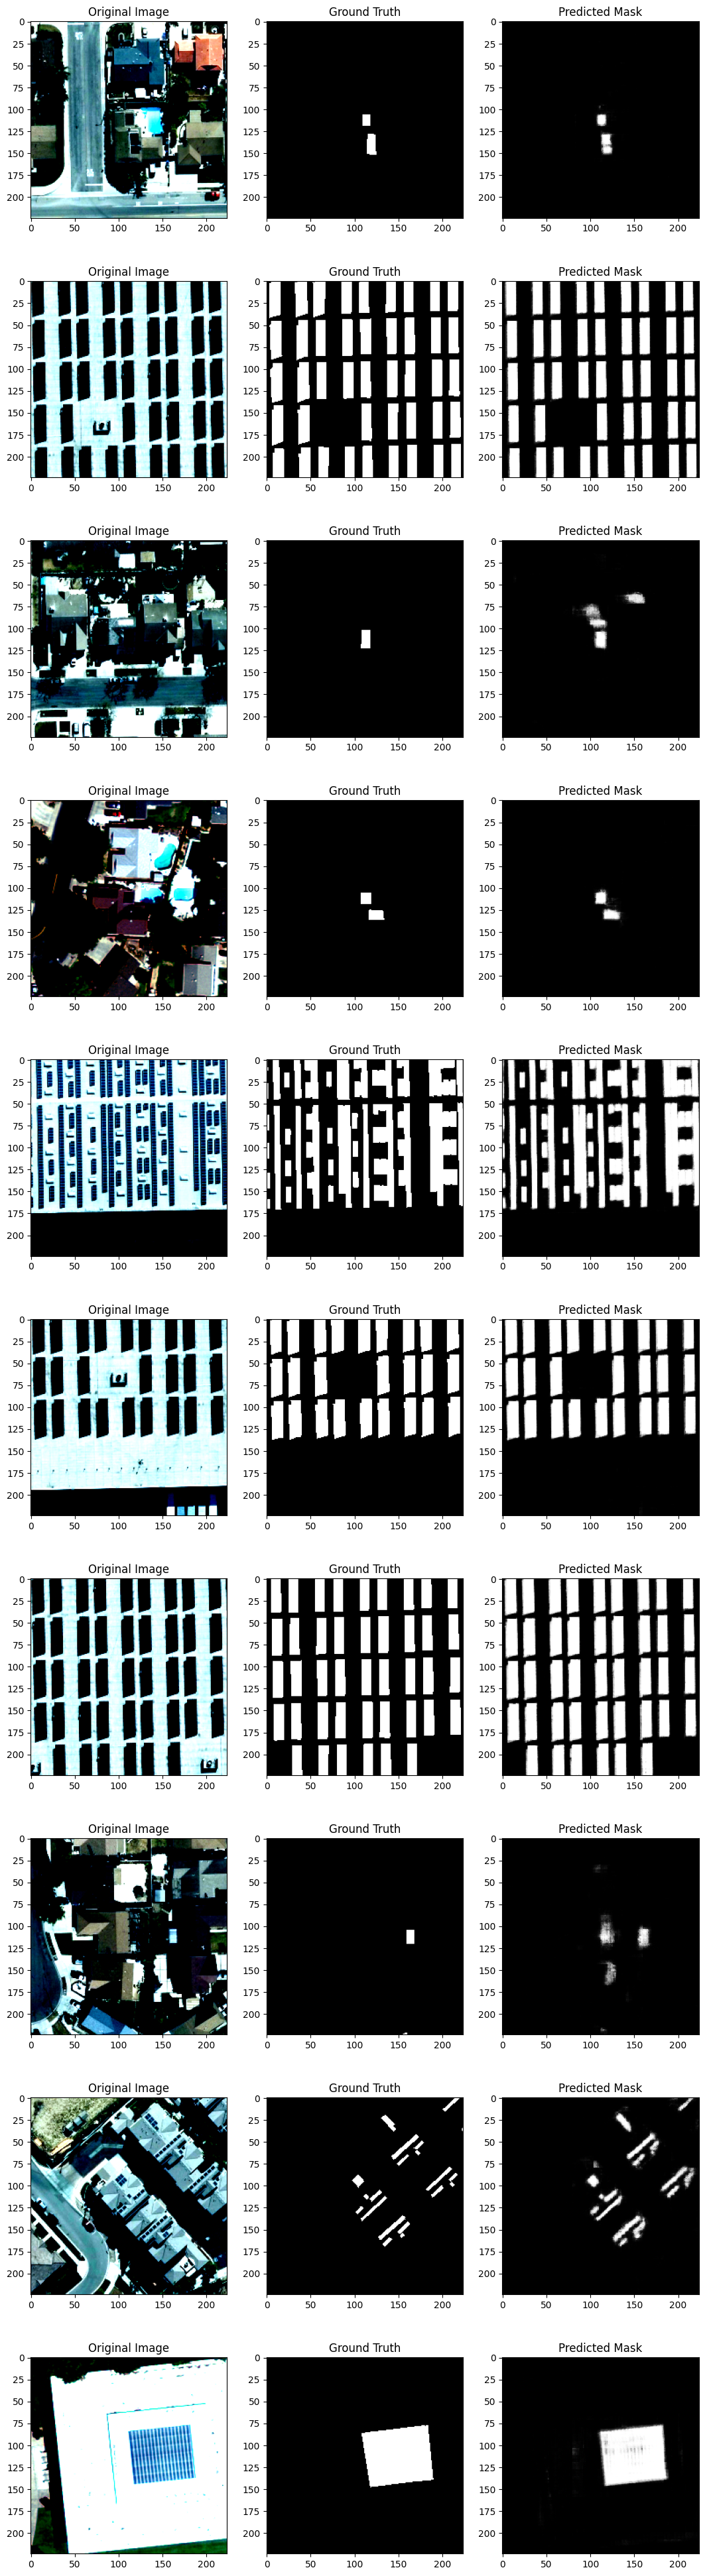

In [71]:
runner.visualize_results()

# **Make a Single Image Predicticon With Saved Calssification/Segmentation Models**

solar panel existence probablity:0.9999973773956299

solar panel area:


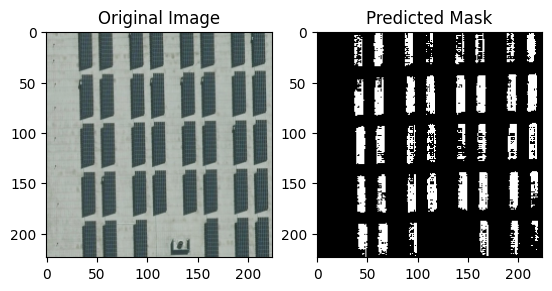

In [277]:
runner.predict()